In [1]:
import torch
import os
import open3d as o3d
from plyfile import PlyData
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import time
import glob
import re
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

print("Current directory:", os.getcwd())

Current directory: /home/dikshantpatel/Dikshant/Semantic_Segmentation/Research


In [3]:
os.chdir("./..")
os.getcwd()

'/home/dikshantpatel/Dikshant/Semantic_Segmentation'

In [4]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print("PyTorch version:", torch.__version__)

if torch.cuda.is_available():
    print("✅ GPU is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("❌ GPU is NOT available.")



PyTorch version: 2.7.1+cu118
✅ GPU is available!
Number of GPUs: 1
  GPU 0: Quadro P4000


In [20]:



# Input PLY files
room_files = [
    'artifacts/train/003_room.ply',
    'artifacts/train/014_room.ply',
    'artifacts/test/018_room.ply',
    'artifacts/train/027_room.ply',
]

# =============================
# Train/Test split definition
# =============================
train_rooms = ["003", "014", "027"]
test_rooms = ["018"]

# Base directory to save processed data
base_output_dir = "../dataset1"
os.makedirs(base_output_dir, exist_ok=True)

# Make train/test directories
train_dir = os.path.join(base_output_dir, "train")
test_dir = os.path.join(base_output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f"📁 Using base output directory: {base_output_dir}")

for room_file in room_files:
    print("=" * 60)
    print(f"📂 Processing File: {room_file}")

    # Extract room number (e.g., "003")
    room_number = os.path.basename(room_file).split('_')[0]
    print(f"🏠 Room number detected: {room_number}")

    # Read PLY
    plydata = PlyData.read(room_file)
    print("📋 Available vertex properties:", plydata['vertex'].data.dtype.names)

    data = plydata['vertex'].data
    x, y, z = data['x'], data['y'], data['z']
    red, green, blue = data['red'], data['green'], data['blue']

    # Optional scalar fields
    scalar_field = data['intensity'] if 'intensity' in data.dtype.names else np.zeros_like(x)
    label = data['label_id'] if 'label_id' in data.dtype.names else np.zeros_like(x)

    # Optional normals
    if all(k in data.dtype.names for k in ['nx', 'ny', 'nz']):
        normals = np.vstack((data['nx'], data['ny'], data['nz'])).T.astype(np.float32)
        print(f"✅ Normals found! Shape: {normals.shape}")
    else:
        normals = None
        print("❌ Normals not found in this file.")

    # Stack data
    points = np.vstack((x, y, z)).T.astype(np.float32)
    colors = np.vstack((red, green, blue)).T.astype(np.uint8)
    scalar_field = scalar_field.astype(np.float32)
    label = label.astype(np.int64)

    # ----------------------------
    # Print stats
    # ----------------------------
    print(f"✅ Points shape:       {points.shape}")
    print(f"🎨 Colors shape:       {colors.shape}")
    print(f"📊 Scalar field shape: {scalar_field.shape}")
    print(f"🏷️ Labels shape:       {label.shape}")

    # ----------------------------
    # Compute unique labels & counts
    # ----------------------------
    unique_labels, counts = np.unique(label, return_counts=True)
    print(f"🏷️ Unique labels in Room {room_number}: {unique_labels}")
    print("📊 Number of points per label:")
    for ul, c in zip(unique_labels, counts):
        print(f"    Label {ul}: {c} points")

    # ----------------------------
    # Decide output folder (train/test)
    # ----------------------------
    if room_number in train_rooms:
        room_output_dir = os.path.join(train_dir, f"{room_number}_room")
    elif room_number in test_rooms:
        room_output_dir = os.path.join(test_dir, f"{room_number}_room")
    else:
        print(f"⚠️ Room {room_number} not assigned to train/test split. Skipping.")
        continue

    os.makedirs(room_output_dir, exist_ok=True)

    # Save files
    np.save(os.path.join(room_output_dir, "coord.npy"), points)
    np.save(os.path.join(room_output_dir, "color.npy"), colors)
    np.save(os.path.join(room_output_dir, "strength.npy"), scalar_field)
    np.save(os.path.join(room_output_dir, "segment.npy"), label)
    if normals is not None:
        np.save(os.path.join(room_output_dir, "normal.npy"), normals)

    print(f"💾 Saved processed data for Room {room_number} in '{room_output_dir}/' ✅\n\n")


📁 Using base output directory: ../dataset
📂 Processing File: artifacts/train/003_room.ply
🏠 Room number detected: 003
📋 Available vertex properties: ('x', 'y', 'z', 'red', 'green', 'blue', 'nx', 'ny', 'nz', 'label_id', 'intensity')
✅ Normals found! Shape: (10538120, 3)
✅ Points shape:       (10538120, 3)
🎨 Colors shape:       (10538120, 3)
📊 Scalar field shape: (10538120,)
🏷️ Labels shape:       (10538120,)
🏷️ Unique labels in Room 003: [  9  14  84  85  86  87  88  91  93  94 107 109 110 111]
📊 Number of points per label:
    Label 9: 2495712 points
    Label 14: 1442539 points
    Label 84: 614262 points
    Label 85: 117578 points
    Label 86: 2671885 points
    Label 87: 1675648 points
    Label 88: 455728 points
    Label 91: 16729 points
    Label 93: 207987 points
    Label 94: 256046 points
    Label 107: 1594 points
    Label 109: 359981 points
    Label 110: 99679 points
    Label 111: 122752 points
💾 Saved processed data for Room 003 in '../dataset/train/003_room/' ✅


📂 Pr

In [6]:
from pathlib import Path
from plyfile import PlyData

def list_ply_features(ply_path: str):
    ply_path = Path(ply_path)
    if not ply_path.exists():
        print(f"❌ File not found: {ply_path}")
        return

    plydata = PlyData.read(ply_path)
    
    print(f"✅ Elements and their properties in {ply_path.name}:")
    for element in plydata.elements:
        print(f"\nElement: {element.name}")
        props = element.data.dtype.names
        if props is None:
            print("  ❌ No properties found")
            continue
        for i, prop in enumerate(props, start=1):
            print(f"  {i}. {prop}")
        print(f"  Total properties: {len(props)}")

# Example usage
ply_file_path = "artifacts/train/003_room.ply"
list_ply_features(ply_file_path)


✅ Elements and their properties in 003_room.ply:

Element: vertex
  1. x
  2. y
  3. z
  4. red
  5. green
  6. blue
  7. nx
  8. ny
  9. nz
  10. scalar_Label_ID
  11. scalar_Scalar_Field
  Total properties: 11


In [8]:
from pathlib import Path
from plyfile import PlyData, PlyElement

# Map of old property names to new names
rename_map = {
    "scalar_Label_ID": "label_id",
    "scalar_Scalar_Field": "intensity"
}

def rename_ply_properties(ply_path: Path):
    plydata = PlyData.read(ply_path)
    new_elements = []
    modified = False

    for element in plydata.elements:
        props = element.data.dtype.names
        new_dtype = []
        for name in props:
            if name in rename_map:
                new_dtype.append((rename_map[name], element.data.dtype[name]))
                modified = True
            else:
                new_dtype.append((name, element.data.dtype[name]))

        # Reconstruct element with new dtype
        new_data = element.data.view(new_dtype).reshape(-1)
        new_element = PlyElement.describe(new_data, element.name)
        new_elements.append(new_element)

    if modified:
        # Reconstruct PlyData with new elements tuple
        new_plydata = PlyData(new_elements, text=plydata.text)
        new_plydata.write(ply_path)
        print(f"✅ Updated: {ply_path}")
    else:
        print(f"ℹ No changes needed: {ply_path}")

def process_all_ply(root_dir: str):
    root_path = Path(root_dir)
    for ply_file in root_path.rglob("*.ply"):
        rename_ply_properties(ply_file)

# Process both train and test folders
process_all_ply("artifacts/train")
process_all_ply("artifacts/test")


✅ Updated: artifacts\train\003_room.ply
✅ Updated: artifacts\train\014_room.ply
✅ Updated: artifacts\train\027_room.ply
✅ Updated: artifacts\test\018_room.ply


In [9]:
import os
from pathlib import Path
import numpy as np
from plyfile import PlyData


# --------------------------
# Helper functions
# --------------------------
def extract_room_number(filename: str) -> str:
    """
    Extract a room identifier from the filename.
    Default: take the first sequence of digits found in the name.
    """
    import re
    match = re.search(r'\d+', os.path.basename(filename))
    if match:
        return match.group(0)
    else:
        return os.path.splitext(os.path.basename(filename))[0]


def process_ply_file(ply_file: str):
    """
    Read a PLY file and return points, colors, scalar field, label, normals, and available properties.
    """
    plydata = PlyData.read(ply_file)
    data = plydata['vertex'].data

    # Print available properties
    vertex_properties = data.dtype.names
    print(f"📋 Available vertex properties: {vertex_properties}")

    x, y, z = data['x'], data['y'], data['z']
    red, green, blue = data['red'], data['green'], data['blue']

    scalar_field = data['intensity'] if 'intensity' in data.dtype.names else np.zeros_like(x)
    label = data['label_id'] if 'label_id' in data.dtype.names else np.zeros_like(x)

    normals = None
    if all(k in data.dtype.names for k in ['nx', 'ny', 'nz']):
        normals = np.vstack((data['nx'], data['ny'], data['nz'])).T.astype(np.float32)
        print(f"✅ Normals found! Shape: {normals.shape}")
    else:
        print("❌ Normals not found in this file.")

    points = np.vstack((x, y, z)).T.astype(np.float32)
    colors = np.vstack((red, green, blue)).T.astype(np.uint8)
    scalar_field = scalar_field.astype(np.float32)
    label = label.astype(np.int64)

    return points, colors, scalar_field, label, normals


def save_processed_data(output_dir: str, points, colors, scalar_field, label, normals=None):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "coord.npy"), points)
    np.save(os.path.join(output_dir, "color.npy"), colors)
    np.save(os.path.join(output_dir, "strength.npy"), scalar_field)
    np.save(os.path.join(output_dir, "segment.npy"), label)
    if normals is not None:
        np.save(os.path.join(output_dir, "normal.npy"), normals)


# --------------------------
# Main processing function
# --------------------------
def process_artifacts(base_dir: str = "artifacts", output_dir: str = "../dataset"):
    """
    Process all PLY files in artifacts/train and artifacts/test.
    Automatically assigns train/test based on folder.
    """
    print(f"📁 Using base output directory: {output_dir}")
    base_output_dir = Path(output_dir)
    train_output = base_output_dir / "train"
    test_output = base_output_dir / "test"

    for split in ["train", "test"]:
        input_dir = Path(base_dir) / split
        if not input_dir.exists():
            print(f"⚠️ Input directory does not exist: {input_dir}")
            continue

        ply_files = list(input_dir.glob("*.ply"))
        print(f"Processing {len(ply_files)} files in '{input_dir}'...")

        for ply_file in ply_files:
            print("=" * 60)
            print(f"📂 Processing File: {ply_file}")

            room_number = extract_room_number(str(ply_file))
            print(f"🏠 Room number detected: {room_number}")

            points, colors, scalar_field, label, normals = process_ply_file(str(ply_file))

            # Print detailed info
            print(f"✅ Points shape:       {points.shape}")
            print(f"🎨 Colors shape:       {colors.shape}")
            print(f"📊 Scalar field shape: {scalar_field.shape}")
            print(f"🏷️ Labels shape:       {label.shape}")

            unique_labels, counts = np.unique(label, return_counts=True)
            print(f"🏷️ Unique labels in Room {room_number}: {unique_labels}")
            print("📊 Number of points per label:")
            for ul, c in zip(unique_labels, counts):
                print(f"    Label {ul}: {c} points")

            # Determine output folder
            output_split_dir = train_output if split == "train" else test_output
            room_output_dir = output_split_dir / f"{room_number}_room"

            save_processed_data(str(room_output_dir), points, colors, scalar_field, label, normals)
            print(f"💾 Saved processed data for Room {room_number} in '{room_output_dir}/' ✅\n\n")


# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    process_artifacts()


📁 Using base output directory: ../dataset
Processing 3 files in 'artifacts\train'...
📂 Processing File: artifacts\train\003_room.ply
🏠 Room number detected: 003
📋 Available vertex properties: ('x', 'y', 'z', 'red', 'green', 'blue', 'nx', 'ny', 'nz', 'label_id', 'intensity')
✅ Normals found! Shape: (10538120, 3)
✅ Points shape:       (10538120, 3)
🎨 Colors shape:       (10538120, 3)
📊 Scalar field shape: (10538120,)
🏷️ Labels shape:       (10538120,)
🏷️ Unique labels in Room 003: [  9  14  84  85  86  87  88  91  93  94 107 109 110 111]
📊 Number of points per label:
    Label 9: 2495712 points
    Label 14: 1442539 points
    Label 84: 614262 points
    Label 85: 117578 points
    Label 86: 2671885 points
    Label 87: 1675648 points
    Label 88: 455728 points
    Label 91: 16729 points
    Label 93: 207987 points
    Label 94: 256046 points
    Label 107: 1594 points
    Label 109: 359981 points
    Label 110: 99679 points
    Label 111: 122752 points
💾 Saved processed data for Room 0

In [31]:

# =============================
# Label mapping function
# =============================
def remap_labels(segment_file):
    """
    Read the segment.npy file, remap labels to 0,1,2,..., save back, and print mapping
    """
    labels = np.load(segment_file)
    unique_labels = np.unique(labels)
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

    print(f"🔄 Remapping labels in '{segment_file}':")
    for old, new in label_map.items():
        print(f"    Original Label {old} -> New Label {new}")

    # Apply mapping
    remapped_labels = np.vectorize(label_map.get)(labels)
    np.save(segment_file, remapped_labels)
    print(f"💾 Saved remapped labels back to '{segment_file}'\n")
    return label_map

# =============================
# Example usage
# =============================
# Assuming you have saved segment.npy for each room, e.g.:
dataset_root = "dataset"  # your base dataset directory
splits = ["train", "test"]

for split in splits:
    split_dir = os.path.join(dataset_root, split)
    for room_folder in os.listdir(split_dir):
        room_path = os.path.join(split_dir, room_folder)
        segment_file = os.path.join(room_path, "segment.npy")
        if os.path.exists(segment_file):
            remap_labels(segment_file)


🔄 Remapping labels in 'dataset/train/014_room/segment.npy':
    Original Label 9 -> New Label 0
    Original Label 14 -> New Label 1
    Original Label 84 -> New Label 2
    Original Label 85 -> New Label 3
    Original Label 86 -> New Label 4
    Original Label 87 -> New Label 5
    Original Label 88 -> New Label 6
    Original Label 91 -> New Label 7
    Original Label 93 -> New Label 8
    Original Label 94 -> New Label 9
    Original Label 107 -> New Label 10
    Original Label 109 -> New Label 11
    Original Label 110 -> New Label 12
    Original Label 111 -> New Label 13
💾 Saved remapped labels back to 'dataset/train/014_room/segment.npy'

🔄 Remapping labels in 'dataset/train/027_room/segment.npy':
    Original Label 9 -> New Label 0
    Original Label 14 -> New Label 1
    Original Label 84 -> New Label 2
    Original Label 85 -> New Label 3
    Original Label 86 -> New Label 4
    Original Label 87 -> New Label 5
    Original Label 88 -> New Label 6
    Original Label 91 -> Ne


Visualizing train split...


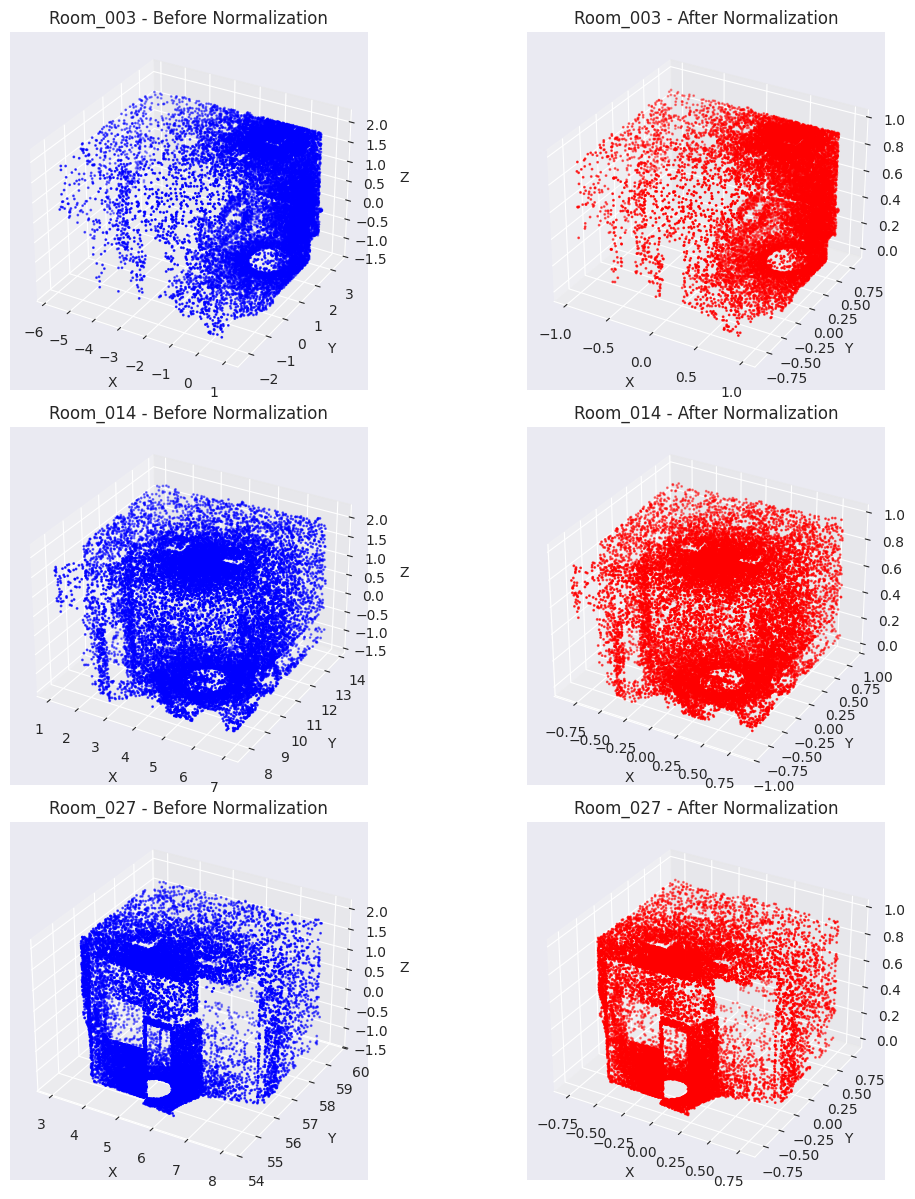


Visualizing test split...


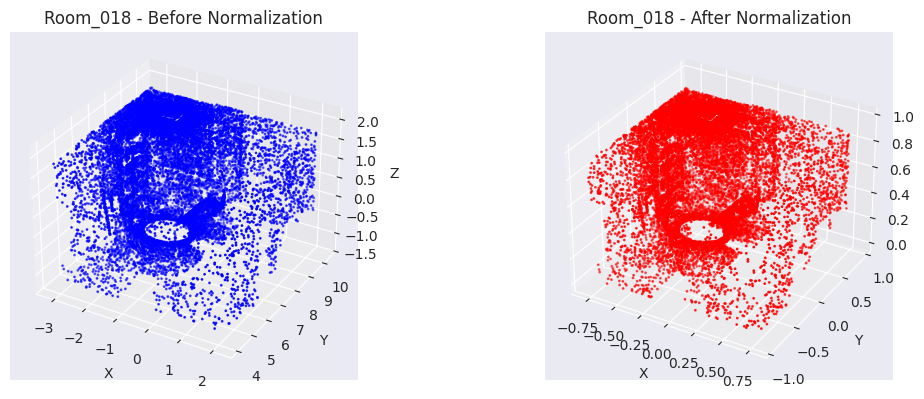

In [22]:


# ==============================
# Settings
# ==============================
dataset_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset"

# Optional: map folder names to friendly room names
room_name_map = {
    "003_room": "Room_003",
    "014_room": "Room_014",
    "018_room": "Room_018",
    "027_room": "Room_027"
}

# ==============================
# Normalize function
# ==============================
def normalize_room(coords: np.ndarray):
    min_vals = coords.min(axis=0)
    max_vals = coords.max(axis=0)

    center_xy = (min_vals[:2] + max_vals[:2]) / 2.0
    coords_centered = coords.copy()
    coords_centered[:, :2] -= center_xy

    z_min = coords_centered[:, 2].min()
    coords_centered[:, 2] -= z_min

    max_range = np.abs(coords_centered).max()
    if max_range > 0:
        coords_norm = coords_centered / max_range
    else:
        coords_norm = coords_centered

    return coords_norm, np.hstack([center_xy, z_min]), max_range

# ==============================
# Load coordinates per room
# ==============================
def load_coords_per_split(split_dir):
    room_coords = {}
    for room_name in sorted(os.listdir(split_dir)):
        room_path = os.path.join(split_dir, room_name)
        coord_file = os.path.join(room_path, "coord.npy")
        if os.path.isdir(room_path) and os.path.exists(coord_file):
            coords = np.load(coord_file)
            room_coords[room_name] = coords
    return room_coords

# ==============================
# Ensure normalization
# ==============================
def ensure_normalization(root_dir, room_coords):
    for room, coords in room_coords.items():
        norm_file = os.path.join(root_dir, room, "coord_norm.npy")
        if not os.path.exists(norm_file):
            coords_norm, center, scale = normalize_room(coords)
            np.save(norm_file, coords_norm)
            print(f"{room}: center={center}, scale={scale:.3f} -> saved {norm_file}")

# ==============================
# Visualization
# ==============================
def visualize_rooms(split_name, split_dir, room_coords, room_name_map):
    print(f"\nVisualizing {split_name} split...")
    num_rooms = len(room_coords)
    if num_rooms == 0:
        print(f"No rooms found in {split_dir}")
        return

    cols = 2
    rows = num_rooms
    fig = plt.figure(figsize=(12, rows * 4))

    for i, room in enumerate(sorted(room_coords.keys())):
        coords_before = room_coords[room]

        # Load normalized coordinates
        norm_file = os.path.join(split_dir, room, "coord_norm.npy")
        coords_after = np.load(norm_file) if os.path.exists(norm_file) else coords_before

        # Sample points
        sample_points = 20000
        idx_before = np.random.choice(coords_before.shape[0], size=min(sample_points, coords_before.shape[0]), replace=False)
        idx_after = np.random.choice(coords_after.shape[0], size=min(sample_points, coords_after.shape[0]), replace=False)

        coords_before_sample = coords_before[idx_before]
        coords_after_sample = coords_after[idx_after]

        # Friendly name
        room_display_name = room_name_map.get(room, room)

        # Plot before normalization
        ax_before = fig.add_subplot(rows, cols, i * cols + 1, projection='3d')
        ax_before.scatter(coords_before_sample[:, 0], coords_before_sample[:, 1], coords_before_sample[:, 2],
                          s=1, c='blue')
        ax_before.set_title(f"{room_display_name} - Before Normalization")
        ax_before.set_xlabel("X")
        ax_before.set_ylabel("Y")
        ax_before.set_zlabel("Z")

        # Plot after normalization
        ax_after = fig.add_subplot(rows, cols, i * cols + 2, projection='3d')
        ax_after.scatter(coords_after_sample[:, 0], coords_after_sample[:, 1], coords_after_sample[:, 2],
                         s=1, c='red')
        ax_after.set_title(f"{room_display_name} - After Normalization")
        ax_after.set_xlabel("X")
        ax_after.set_ylabel("Y")
        ax_after.set_zlabel("Z")

    plt.tight_layout()
    plt.show()


# ==============================
# Main
# ==============================
if __name__ == "__main__":
    # Loop over train/test splits
    for split_name in ["train", "test"]:
        split_dir = os.path.join(dataset_root, split_name)
        room_coords = load_coords_per_split(split_dir)
        ensure_normalization(split_dir, room_coords)
        visualize_rooms(split_name, split_dir, room_coords, room_name_map)


In [34]:



def chunk_room(
    room_name,
    dataset_root,
    split_name,
    chunk_range=(6, 6),
    chunk_stride=(3, 3),
    chunk_minimum_size=10000,
    grid_size=None,
):
    messages = []
    messages.append(f"Processing room: {room_name} in {split_name} split")

    room_path = Path(dataset_root) / split_name / room_name

    # Load all features
    coord = np.load(room_path / "coord.npy")
    coord_norm = np.load(room_path / "coord_norm.npy")
    color = np.load(room_path / "color.npy")
    normal = np.load(room_path / "normal.npy")
    segment = np.load(room_path / "segment.npy")
    strength = np.load(room_path / "strength.npy")

    working_coord = coord.copy()  # you can switch to coord_norm if you prefer

    # ✅ Grid subsampling if grid_size is given
    if grid_size is not None:
        grid_coord = np.floor(working_coord / grid_size).astype(np.int64)
        _, unique_idx = np.unique(grid_coord, axis=0, return_index=True)

        # Apply subsampling to all features
        coord = coord[unique_idx]
        coord_norm = coord_norm[unique_idx]
        color = color[unique_idx]
        normal = normal[unique_idx]
        segment = segment[unique_idx]
        strength = strength[unique_idx]
        working_coord = coord  # update working_coord after subsampling

        messages.append(f"✅ Applied grid subsampling with grid_size={grid_size}, kept {len(coord)} points")

    # ✅ Compute bounding box for chunking
    x_min, y_min = working_coord[:, :2].min(axis=0)
    x_max, y_max = working_coord[:, :2].max(axis=0)

    x_grid = np.arange(x_min, x_max - chunk_range[0] + chunk_stride[0], chunk_stride[0])
    y_grid = np.arange(y_min, y_max - chunk_range[1] + chunk_stride[1], chunk_stride[1])
    chunks = np.array(np.meshgrid(x_grid, y_grid, indexing="ij")).T.reshape(-1, 2)

    chunk_idx = 0
    for chunk_start in chunks:
        x0, y0 = chunk_start
        mask = (
            (working_coord[:, 0] >= x0) & (working_coord[:, 0] < x0 + chunk_range[0]) &
            (working_coord[:, 1] >= y0) & (working_coord[:, 1] < y0 + chunk_range[1])
        )

        if np.sum(mask) < chunk_minimum_size:
            continue

        chunk_name = f"{room_name}_{chunk_idx}"
        chunk_folder = Path(dataset_root) / split_name / "chunks" / chunk_name
        chunk_folder.mkdir(parents=True, exist_ok=True)

        # Save features
        np.save(chunk_folder / "coord.npy", coord[mask])
        np.save(chunk_folder / "coord_norm.npy", coord_norm[mask])
        np.save(chunk_folder / "color.npy", color[mask])
        np.save(chunk_folder / "normal.npy", normal[mask])
        np.save(chunk_folder / "segment.npy", segment[mask])
        np.save(chunk_folder / "strength.npy", strength[mask])

        messages.append(f"💾 Saved chunk {chunk_idx} for {room_name} ({np.sum(mask)} points)")
        chunk_idx += 1

    if chunk_idx == 0:
        messages.append(f"⚠️ No chunks created for {room_name} (not enough points).")

    return messages


def process_split(
    dataset_root,
    split_name,
    chunk_range=(6, 6),
    chunk_stride=(3, 3),
    chunk_minimum_size=10000,
    grid_size=None,
    num_workers=None,
):
    split_dir = Path(dataset_root) / split_name
    room_list = [d.name for d in split_dir.iterdir() if d.is_dir()]
    print(f"Found rooms in {split_name}: {room_list}\n")

    if num_workers is None:
        num_workers = mp.cpu_count()

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for room_messages in executor.map(
            chunk_room,
            room_list,
            repeat(dataset_root),
            repeat(split_name),
            repeat(chunk_range),
            repeat(chunk_stride),
            repeat(chunk_minimum_size),
            repeat(grid_size),
        ):
            for msg in room_messages:
                print(msg)
            print("")


if __name__ == "__main__":
    dataset_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset"

    # Process both splits separately
    for split in ["train", "test"]:
        print(f"\n==================== Processing split: {split} ====================\n")
        process_split(
            dataset_root=dataset_root,
            split_name=split,
            chunk_range=(2, 2),
            chunk_stride=(1, 1),
            chunk_minimum_size=1,
            grid_size=0.01,
            num_workers=2
        )



==================== Processing split: train ====================

Found rooms in train: ['014_room', '027_room', '003_room']

Processing room: 014_room in train split
✅ Applied grid subsampling with grid_size=0.01, kept 1327220 points
💾 Saved chunk 0 for 014_room (135108 points)
💾 Saved chunk 1 for 014_room (154158 points)
💾 Saved chunk 2 for 014_room (137203 points)
💾 Saved chunk 3 for 014_room (159492 points)
💾 Saved chunk 4 for 014_room (202714 points)
💾 Saved chunk 5 for 014_room (126989 points)
💾 Saved chunk 6 for 014_room (110215 points)
💾 Saved chunk 7 for 014_room (108780 points)
💾 Saved chunk 8 for 014_room (85134 points)
💾 Saved chunk 9 for 014_room (82275 points)
💾 Saved chunk 10 for 014_room (163450 points)
💾 Saved chunk 11 for 014_room (120782 points)
💾 Saved chunk 12 for 014_room (125181 points)
💾 Saved chunk 13 for 014_room (88610 points)
💾 Saved chunk 14 for 014_room (85930 points)
💾 Saved chunk 15 for 014_room (85284 points)
💾 Saved chunk 16 for 014_room (160941 poin

In [4]:
if __name__ == "__main__":
    dataset_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset"

    # Process both splits separately
    for split in ["test"]:
        print(f"\n==================== Processing split: {split} ====================\n")
        process_split(
            dataset_root=dataset_root,
            split_name=split,
            chunk_range=(3, 3),
            chunk_stride=(2, 2),
            chunk_minimum_size=1,
            grid_size=0.01,
            num_workers=2
        )



==================== Processing split: test ====================

Found rooms in test: ['018_room']

Processing room: 018_room in test split
✅ Applied grid subsampling with grid_size=0.01, kept 1087407 points
💾 Saved chunk 0 for 018_room (265367 points)
💾 Saved chunk 1 for 018_room (161363 points)
💾 Saved chunk 2 for 018_room (148892 points)
💾 Saved chunk 3 for 018_room (308002 points)
💾 Saved chunk 4 for 018_room (139389 points)
💾 Saved chunk 5 for 018_room (98497 points)
💾 Saved chunk 6 for 018_room (339388 points)
💾 Saved chunk 7 for 018_room (180903 points)
💾 Saved chunk 8 for 018_room (86475 points)



In [5]:


def merge_room_chunks(room_name, chunks_root, use_colors=True):
    """
    Merge all chunks1 of a room into a single point cloud for visualization.

    Args:
        room_name (str): Room name like '014_room'.
        chunks_root (str): Path to the chunks1 folder.
        use_colors (bool): If True, use color.npy from chunks1.

    Returns:
        o3d.geometry.PointCloud
    """
    chunks_root = Path(chunks_root)
    room_chunks = sorted(chunks_root.glob(f"{room_name}_*"))

    if len(room_chunks) == 0:
        print(f"No chunks1 found for {room_name}")
        return None

    all_points = []
    all_colors = []

    for idx, chunk_path in enumerate(room_chunks):
        coords = np.load(chunk_path / "coord.npy")
        all_points.append(coords)

        if use_colors:
            colors = np.load(chunk_path / "color.npy") / 255.0
            # Optionally, assign a unique color per chunk
            chunk_color = np.random.rand(3)  # random color for the chunk
            colors[:] = chunk_color
            all_colors.append(colors)

    all_points = np.vstack(all_points)
    if use_colors:
        all_colors = np.vstack(all_colors)

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(all_points)
    if use_colors:
        pcd.colors = o3d.utility.Vector3dVector(all_colors)

    return pcd


if __name__ == "__main__":
    chunks_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/chunks"
    room_name = "018_room"  # change to any room you want

    pcd = merge_room_chunks(room_name, chunks_root)
    if pcd:
        print(f"Visualizing merged room: {room_name}, total points: {len(pcd.points)}")
        o3d.visualization.draw_geometries(
            [pcd],
            window_name=f"Merged Room: {room_name}",
            width=1280,
            height=720,
            point_show_normal=False
        )


Visualizing merged room: 018_room, total points: 1728276


In [23]:


# Base dataset folder
dataset_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset"

splits = ["train", "test"]

for split in splits:
    print(f"\n================ Stats for {split.upper()} split ================\n")

    base_dir = os.path.join(dataset_root, split, "chunks")
    room_stats = defaultdict(lambda: {"points": 0, "labels": []})

    # Loop through all chunk folders
    if os.path.exists(base_dir):
        for folder in sorted(os.listdir(base_dir)):
            folder_path = os.path.join(base_dir, folder)
            if os.path.isdir(folder_path):
                # Extract room name prefix (e.g. "003_room" from "003_room_5")
                room_name = "_".join(folder.split("_")[:2])

                segment_file = os.path.join(folder_path, "segment.npy")
                if os.path.exists(segment_file):
                    labels = np.load(segment_file)
                    room_stats[room_name]["labels"].append(labels)
                    room_stats[room_name]["points"] += labels.shape[0]

        # Print results per room
        if room_stats:
            for room_name, stats in sorted(room_stats.items()):
                all_labels = np.concatenate(stats["labels"]) if stats["labels"] else np.array([])
                unique_labels = np.unique(all_labels) if all_labels.size > 0 else []
                print(f"🏠 Room: {room_name}")
                print(f"   ✅ Total points: {stats['points']}")
                print(f"   ✅ Unique classes: {unique_labels.tolist()}")
                print(f"   ✅ Number of unique classes: {len(unique_labels)}\n")
        else:
            print(f"⚠️ No segment.npy files found in {split} chunks.")
    else:
        print(f"⚠️ Directory does not exist: {base_dir}")



================ Stats for TRAIN split ================

🏠 Room: 003_room
   ✅ Total points: 2812648
   ✅ Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
   ✅ Number of unique classes: 14

🏠 Room: 014_room
   ✅ Total points: 4113209
   ✅ Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
   ✅ Number of unique classes: 14

🏠 Room: 027_room
   ✅ Total points: 2461300
   ✅ Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
   ✅ Number of unique classes: 14


================ Stats for TEST split ================

🏠 Room: 018_room
   ✅ Total points: 1728276
   ✅ Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
   ✅ Number of unique classes: 14



In [25]:
from torch.utils.data import Dataset
# =========================
# Device setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# =========================
# GPU-based Farthest Point Sampling
# =========================
def farthest_point_sample_gpu(xyz, npoint):
    N, _ = xyz.shape
    device = xyz.device
    sampled_idx = torch.zeros(npoint, dtype=torch.long, device=device)
    distances = torch.ones(N, device=device) * 1e10
    farthest = torch.randint(0, N, (1,), device=device).item()

    for i in range(npoint):
        sampled_idx[i] = farthest
        centroid = xyz[farthest].unsqueeze(0)
        dist = torch.sum((xyz - centroid) ** 2, dim=1)
        distances = torch.minimum(distances, dist)
        farthest = torch.argmax(distances).item()
    return sampled_idx


# =========================
# Data augmentation
# =========================
def augment_pointcloud(coords, features):
    theta = np.random.uniform(0, 2 * np.pi)
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    coords = coords @ rot_matrix.T
    coords += np.random.normal(0, 0.01, coords.shape)
    return coords, features


# =========================
# Dataset class
# =========================
class PointCloudChunkDataset(Dataset):
    def __init__(self, root_dir, chunk_size=4096, augment=False):
        self.root_dir = root_dir
        self.chunk_size = chunk_size
        self.augment = augment
        self.chunks = []
        self.chunk_names = []
        self._load_and_chunk()

    def _load_patch(self, patch_path):
        coords = np.load(os.path.join(patch_path, "coord_norm.npy")).astype(np.float32)
        colors = np.load(os.path.join(patch_path, "color.npy")).astype(np.float32)
        normals = np.load(os.path.join(patch_path, "normal.npy")).astype(np.float32)
        labels = np.load(os.path.join(patch_path, "segment.npy")).astype(np.int64)
        strength = np.load(os.path.join(patch_path, "strength.npy")).astype(np.float32)
        features = np.concatenate([colors, normals, strength[:, np.newaxis]], axis=1)
        return coords, features, labels

    def _chunk_patch(self, coords, features, labels, patch_name):
        N = coords.shape[0]
        chunks, names = [], []
        remaining_idx = np.arange(N)
        chunk_idx = 0

        coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
        features_tensor = torch.tensor(features, dtype=torch.float32, device=device)
        labels_tensor = torch.tensor(labels, dtype=torch.long, device=device)

        while len(remaining_idx) > 0:
            if len(remaining_idx) < self.chunk_size:
                sampled_idx = torch.tensor(
                    np.random.choice(remaining_idx, self.chunk_size, replace=True),
                    device=device,
                    dtype=torch.long
                )
            else:
                sampled_idx_local = farthest_point_sample_gpu(coords_tensor[remaining_idx], self.chunk_size)
                sampled_idx = torch.tensor(remaining_idx, device=device)[sampled_idx_local]

            chunk_coords = coords_tensor[sampled_idx]
            chunk_features = features_tensor[sampled_idx]
            chunk_labels = labels_tensor[sampled_idx]

            chunks.append({
                "coords_norms": chunk_coords,
                "features": chunk_features,
                "labels": chunk_labels
            })
            names.append(f"{patch_name}_chunk_{chunk_idx}")
            chunk_idx += 1
            remaining_idx = np.setdiff1d(remaining_idx, sampled_idx.cpu().numpy())

        return chunks, names

    def _load_and_chunk(self):
        print("Loading patches and creating chunks...")
        area_folders = sorted([f for f in os.listdir(self.root_dir)
                               if os.path.isdir(os.path.join(self.root_dir, f))])
        total_chunks = 0
        for area in area_folders:
            coords, features, labels = self._load_patch(os.path.join(self.root_dir, area))
            chunks, names = self._chunk_patch(coords, features, labels, area)
            self.chunks.extend(chunks)
            self.chunk_names.extend(names)
            total_chunks += len(chunks)
            print(f"Processed {area}: {len(chunks)} chunks")
        print(f"Total chunks created: {total_chunks}")

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        coords = chunk["coords_norms"]
        features = chunk["features"]
        labels = chunk["labels"]
        if self.augment:
            coords_np = coords.cpu().numpy()
            features_np = features.cpu().numpy()
            coords_np, features_np = augment_pointcloud(coords_np, features_np)
            coords = torch.tensor(coords_np, dtype=torch.float32, device=device)
            features = torch.tensor(features_np, dtype=torch.float32, device=device)
        return torch.cat([coords, features], dim=1), labels


# =========================
# Save chunks function
# =========================
def save_dataset_chunks(root_dir, save_dir, chunk_size=4096, augment=False):
    dataset = PointCloudChunkDataset(root_dir, chunk_size, augment=augment)
    print(f"\nProcessing dataset: {root_dir}")
    print(f"Total patches: {len(dataset)}")
    print(f"Feature shape per patch: {dataset[0][0].shape}")

    os.makedirs(save_dir, exist_ok=True)
    area_to_chunks = defaultdict(list)
    for i, chunk_name in enumerate(dataset.chunk_names):
        area = chunk_name.split("_chunk_")[0]
        area_to_chunks[area].append((i, chunk_name))

    for area, chunk_list in area_to_chunks.items():
        for patch_num, (idx, chunk_name) in enumerate(chunk_list, start=1):
            chunk_suffix = chunk_name.split(f"{area}_")[-1]
            new_filename = f"{area}_{patch_num}{chunk_suffix}.npz"
            filepath = os.path.join(save_dir, new_filename)

            chunk = dataset.chunks[idx]
            np.savez_compressed(filepath,
                                coords=chunk['coords_norms'].cpu().numpy(),
                                features=chunk['features'].cpu().numpy(),
                                labels=chunk['labels'].cpu().numpy())

    np.save(os.path.join(save_dir, "chunk_names.npy"), np.array(dataset.chunk_names))
    print(f"Saved chunks to {save_dir}")



Using device: cuda


In [ ]:
if __name__ == "__main__":
    test_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/chunks"
    test_save = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/saved_same_size_chunks_test"
    save_dataset_chunks(test_root, test_save, chunk_size=4000, augment=False)


In [26]:

if __name__ == "__main__":
    test_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/chunks"
    test_save = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/saved_same_size_chunks_test"
    save_dataset_chunks(test_root, test_save, chunk_size=4000, augment=False)

Loading patches and creating chunks...
Processed 018_room_0: 68 chunks
Processed 018_room_1: 42 chunks
Processed 018_room_2: 39 chunks
Processed 018_room_3: 78 chunks
Processed 018_room_4: 37 chunks
Processed 018_room_5: 26 chunks
Processed 018_room_6: 87 chunks
Processed 018_room_7: 47 chunks
Processed 018_room_8: 23 chunks
Total chunks created: 447

Processing dataset: /home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/chunks
Total patches: 447
Feature shape per patch: torch.Size([4000, 10])
Saved chunks to /home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/saved_same_size_chunks_test


In [42]:


chunk_dir = "/dataset/train/saved_same_size_chunks_train"

expected_shapes = {
    'coords': (4000, 3),
    'features': (4000, 7),
    'labels': (4000,)
}

bad_files_found = False
file_count = 0  # Counter for .npz files

for file in sorted(os.listdir(chunk_dir)):
    if not file.endswith(".npz"):
        continue

    file_count += 1
    fpath = os.path.join(chunk_dir, file)
    data = np.load(fpath)

    coords = data['coords']
    features = data['features']
    labels = data['labels']

    if coords.shape != expected_shapes['coords'] or \
       features.shape != expected_shapes['features'] or \
       labels.shape != expected_shapes['labels']:
        bad_files_found = True
        print(f"{file} has unexpected shapes:")
        print(f"  coords: {coords.shape}")
        print(f"  features: {features.shape}")
        print(f"  labels: {labels.shape}")

print(f"\n📦 Total .npz files found: {file_count}")

if not bad_files_found:
    print("✅ All chunk files have 4000 points and expected shapes.")



📦 Total .npz files found: 2498
✅ All chunk files have 4000 points and expected shapes.


In [5]:



# === Helper functions ===

def square_distance(src, dst):
    """
    Calculate squared Euclidean distance between each two points
    src: [B, N, C]
    dst: [B, M, C]
    Returns: [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))  # [B, N, M]
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: [B, N, 3] points
        npoint: number of points to sample
    Return:
        centroids: [B, npoint] sampled point indices
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid_xyz = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid_xyz) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def index_points(points, idx):
    """
    Input:
        points: [B, N, C]
        idx: [B, S] or [B, S, K]
    Return:
        new_points: [B, S, C] or [B, S, K, C]
    """
    device = points.device
    B = points.shape[0]

    if idx.dim() == 2:
        # idx: [B, S]
        batch_indices = torch.arange(B, dtype=torch.long).to(device).view(B, 1).repeat(1, idx.shape[1])
        new_points = points[batch_indices, idx, :]
    elif idx.dim() == 3:
        # idx: [B, S, K]
        batch_indices = torch.arange(B, dtype=torch.long).to(device).view(B, 1, 1).repeat(1, idx.shape[1], idx.shape[2])
        new_points = points[batch_indices, idx, :]
    else:
        raise ValueError(f"Unsupported idx shape: {idx.shape}")

    return new_points


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Find neighboring points within a radius.
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    B, N, _ = xyz.shape
    S = new_xyz.shape[1]
    device = xyz.device

    sqrdists = square_distance(new_xyz, xyz)  # [B, S, N]
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])  # [B, S, N]
    mask = sqrdists > radius ** 2
    group_idx[mask] = N  # invalid points set to N (padding idx)
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]  # take nearest nsample points
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]  # replace invalid points with first point to avoid empty group
    return group_idx


# === PointNet Set Abstraction Layer ===
class PointNetSetAbstraction5(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp_channels):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel + 3  # +3 for relative position encoding

        for out_channel in mlp_channels:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        """
        Input:
            xyz: [B, 3, N]
            points: [B, D, N]
        Return:
            new_xyz: sampled points [B, 3, S]
            new_points: features [B, D_new, S]
        """
        B, _, N = xyz.shape
        xyz = xyz.permute(0, 2, 1)  # [B, N, 3]

        # Sampling
        if self.npoint is not None:
            fps_idx = farthest_point_sample(xyz, self.npoint)  # [B, npoint]
            new_xyz = index_points(xyz, fps_idx)  # [B, npoint, 3]
        else:
            new_xyz = xyz

        # Grouping
        group_idx = query_ball_point(self.radius, self.nsample, xyz, new_xyz)  # [B, npoint, nsample]
        grouped_xyz = index_points(xyz, group_idx)  # [B, npoint, nsample, 3]
        grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)  # normalize

        if points is not None:
            points = points.permute(0, 2, 1)  # [B, N, D]
            grouped_points = index_points(points, group_idx)  # [B, npoint, nsample, D]
            new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)  # [B, npoint, nsample, 3+D]
        else:
            new_points = grouped_xyz_norm  # [B, npoint, nsample, 3]

        new_points = new_points.permute(0, 3, 1, 2)  # [B, 3+D, npoint, nsample]

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, -1)[0]  # max pool over nsample dim [B, D_new, npoint]

        new_xyz = new_xyz.permute(0, 2, 1)  # back to [B, 3, npoint]

        return new_xyz, new_points


# === PointNet Feature Propagation Layer ===
class PointNetFeaturePropagation5(nn.Module):
    def __init__(self, in_channel, mlp_channels):
        super().__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp_channels:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Interpolate features from xyz2 (sparser) to xyz1 (denser)
        Input:
            xyz1: [B, 3, N]
            xyz2: [B, 3, S]
            points1: [B, D1, N] (features to be updated)
            points2: [B, D2, S] (features to propagate)
        Return:
            new_points: [B, D_new, N]
        """
        B, C, N = xyz1.shape
        _, _, S = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            xyz1_t = xyz1.permute(0, 2, 1)  # [B, N, 3]
            xyz2_t = xyz2.permute(0, 2, 1)  # [B, S, 3]
            dist = square_distance(xyz1_t, xyz2_t)  # [B, N, S]
            dist, idx = dist.sort(dim=-1)
            dist, idx = dist[:, :, :3], idx[:, :, :3]  # take 3 nearest

            dist_recip = 1.0 / (dist + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm  # [B, N, 3]

            points2 = points2.permute(0, 2, 1)  # [B, S, D2]

            B, N, K = idx.shape
            _, S, D2 = points2.shape

            idx_expanded = idx.unsqueeze(-1).expand(-1, -1, -1, D2)  # [B, N, 3, D2]
            points2_expanded = points2.unsqueeze(1).expand(-1, N, -1, -1)  # [B, N, S, D2]

            neighbor_feats = torch.gather(points2_expanded, 2, idx_expanded)  # [B, N, 3, D2]

            interpolated_points = torch.sum(neighbor_feats * weight.unsqueeze(-1), dim=2)  # [B, N, D2]

            interpolated_points = interpolated_points.permute(0, 2, 1)  # [B, D2, N]

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=1)  # [B, D1+D2, N]
        else:
            new_points = interpolated_points

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        return new_points


# === Full PointNet++ Semantic Segmentation Model ===
import torch
import torch.nn as nn


class PointNet2SemSeg5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.sa1 = PointNetSetAbstraction5(npoint=1024, radius=0.1, nsample=32, in_channel=7, mlp_channels=[32, 32, 64])
        self.sa2 = PointNetSetAbstraction5(npoint=256, radius=0.2, nsample=32, in_channel=64,
                                           mlp_channels=[64, 64, 128])
        self.sa3 = PointNetSetAbstraction5(npoint=64, radius=0.4, nsample=32, in_channel=128,
                                           mlp_channels=[128, 128, 256])

        # ---- Feature Propagation Layers ----
        self.fp3 = PointNetFeaturePropagation5(in_channel=384, mlp_channels=[256, 256])
        self.fp2 = PointNetFeaturePropagation5(in_channel=320, mlp_channels=[256, 128])
        self.fp1 = PointNetFeaturePropagation5(in_channel=135, mlp_channels=[128, 128, 128])

        # ---- Classifier ----
        self.classifier = nn.Sequential(
            nn.Conv1d(128, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(128, num_classes, 1)
        )

    def forward(self, xyz, features):
        """
        Input:
            xyz: [B, 3, N] - point coordinates
            features: [B, 7, N] - extra features (e.g. RGB+scalar)
        Return:
            logits: [B, num_classes, N]
        """
        l1_xyz, l1_points = self.sa1(xyz, features)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(xyz, l1_xyz, features, l1_points)

        logits = self.classifier(l0_points)
        return logits


In [8]:


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# ===================== Helper Functions =====================

def calculate_metrics(pred_labels, true_labels, num_classes):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1_macro = f1_score(true_labels, pred_labels, average='macro', labels=np.arange(num_classes))
    return accuracy, f1_macro


# ===================== Training Loop =====================

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_points, batch_labels in dataloader:
        batch_points = batch_points.to(device)
        batch_labels = batch_labels.to(device)

        xyz = batch_points[:, :, :3].permute(0, 2, 1)
        features = batch_points[:, :, 3:].permute(0, 2, 1)

        optimizer.zero_grad()
        logits = model(xyz, features)

        # Clamp labels to valid range
        num_classes = logits.shape[1]
        batch_labels = torch.clamp(batch_labels, min=0, max=num_classes - 1)

        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = logits.argmax(dim=1).detach().cpu().numpy().reshape(-1)
        labels = batch_labels.detach().cpu().numpy().reshape(-1)
        all_preds.append(preds)
        all_labels.append(labels)

    avg_loss = running_loss / len(dataloader)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy, f1_macro = calculate_metrics(all_preds, all_labels, num_classes)
    return avg_loss, accuracy, f1_macro


# ===================== Main Training Function =====================

def train_model(model, train_loader, class_weights, device,
                epochs=120, lr=0.001, lr_step=20, lr_gamma=0.5,
                save_dir="../trial7/without_validation_trial/all_epochs_models"):
    os.makedirs(save_dir, exist_ok=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    for epoch in range(epochs):
        current_lr = scheduler.get_last_lr()[0]
        print(f"\nEpoch {epoch + 1}/{epochs} | LR: {current_lr:.6f}")

        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
        print(f"  Train loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1-macro: {train_f1:.4f}")

        # Save model every epoch
        ckpt_path = os.path.join(save_dir, f"epoch_{epoch + 1:03d}_pointnet2.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"  Saved model: {ckpt_path}")

        scheduler.step()
        print(f"  Current LR: {scheduler.get_last_lr()[0]:.6f}")

    print("\nTraining complete. All models saved in:", save_dir)



In [ ]:

# ===================== Helper Functions =====================
def calculate_metrics(pred_labels, true_labels, num_classes):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1_macro = f1_score(true_labels, pred_labels, average='macro', labels=np.arange(num_classes))
    return accuracy, f1_macro


def compute_class_weights(root_dir, n_classes):
    npz_files = glob.glob(os.path.join(root_dir, "*.npz"))
    if len(npz_files) == 0:
        raise ValueError(f"No .npz files found in {root_dir}")

    all_labels = []
    for f in npz_files:
        data = np.load(f)
        labels = data['labels'].flatten()
        all_labels.append(labels)

    all_labels = np.concatenate(all_labels)
    counts = np.bincount(all_labels, minlength=n_classes)
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * n_classes
    print("Class weights:", weights)
    return torch.tensor(weights, dtype=torch.float32)


# ===================== Dataset =====================
class PointCloudChunkNPZDataset5(torch.utils.data.Dataset):
    def __init__(self, chunk_dir):
        self.files = sorted([f for f in os.listdir(chunk_dir) if f.endswith(".npz")])
        self.chunk_dir = chunk_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.chunk_dir, self.files[idx])
        data = np.load(path)
        coords = data['coords']
        features = data['features']
        labels = data['labels']
        points = np.hstack([coords, features])
        return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


# ===================== Main Training =====================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 14

    model = PointNet2SemSeg5(num_classes=num_classes).to(device)

    # -------- Compute class weights dynamically --------
    train_chunks_dir = "/dataset/train/saved_same_size_chunks_train"
    class_weights = compute_class_weights(train_chunks_dir, num_classes).to(device)

    train_dataset5 = PointCloudChunkNPZDataset5(train_chunks_dir)
    train_loader5 = DataLoader(train_dataset5, batch_size=3, shuffle=True, num_workers=4)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    epochs = 120
    save_dir = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/saved_models_pointnet++"
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for batch_points, batch_labels in train_loader5:
            batch_points = batch_points.to(device)
            batch_labels = batch_labels.to(device)

            xyz = batch_points[:, :, :3].permute(0, 2, 1)
            features = batch_points[:, :, 3:].permute(0, 2, 1)

            optimizer.zero_grad()
            logits = model(xyz, features)

            batch_labels = torch.clamp(batch_labels, min=0, max=num_classes - 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(dim=1).detach().cpu().numpy().reshape(-1)
            labels = batch_labels.detach().cpu().numpy().reshape(-1)
            all_preds.append(preds)
            all_labels.append(labels)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Save every epoch
        ckpt_path = os.path.join(save_dir, f"epoch_{epoch + 1:03d}_pointnet2.pth")
        torch.save(model.state_dict(), ckpt_path)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {running_loss / len(train_loader5):.4f}, "
              f"Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
              f"LR: {current_lr:.6f}, Time: {time.time() - start_time:.2f}s, "
              f"Saved: {ckpt_path}", flush=True)

    print("\nTraining complete. All models saved in:", save_dir)


if __name__ == "__main__":
    main()


In [ ]:
import os
import re
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# ===================== Dataset =====================
class PointCloudChunkNPZDataset(torch.utils.data.Dataset):
    def __init__(self, chunk_dir):
        self.files = sorted([f for f in os.listdir(chunk_dir) if f.endswith(".npz")])
        self.chunk_dir = chunk_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.chunk_dir, self.files[idx])
        data = np.load(path)
        coords = data['coords']       # (N, 3)
        features = data['features']   # (N, 7)
        labels = data['labels']       # (N,)
        points = np.hstack([coords, features])
        return torch.tensor(points, dtype=torch.float32), \
               torch.tensor(labels, dtype=torch.long), \
               points


# ===================== Test Model =====================
def test_pointnetpp(model_path, test_dir, num_classes, batch_size=2,
                    save_pred_dir="predicted_results", class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_pred_dir, exist_ok=True)

    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    # Extract epoch number (optional)
    epoch_match = re.search(r'epoch_(\d+)_', os.path.basename(model_path))
    epoch_number = int(epoch_match.group(1)) if epoch_match else -1

    # Dataset & dataloader
    dataset = PointCloudChunkNPZDataset(test_dir)
    if len(dataset) == 0:
        print(f"❌ No .npz files found in: {test_dir}")
        return None, None

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Load model
    model = PointNet2SemSeg5(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds, all_labels, merged_points = [], [], []

    with torch.no_grad():
        for batch_points, batch_labels, original_points_list in loader:
            batch_points = batch_points.to(device)
            batch_labels = batch_labels.to(device)

            xyz = batch_points[:, :, :3].permute(0, 2, 1)
            feats = batch_points[:, :, 3:].permute(0, 2, 1)

            logits = model(xyz, feats)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            for i, orig_points in enumerate(original_points_list):
                # Convert tensor to NumPy if needed
                points_np = orig_points.copy() if isinstance(orig_points, np.ndarray) else orig_points.numpy()

                # Denormalize RGB [-1,1] → [-255,255]
                points_np[:, 3:6] = (points_np[:, 3:6] * 255).astype(np.int16)

                # Denormalize Intensity [-1,1] → [-255,255]
                points_np[:, 9] = (points_np[:, 9] * 255).astype(np.int16)

                pred_labels = preds[i].reshape(-1, 1)
                gt_labels = labels[i].reshape(-1, 1)

                merged_points.append(np.hstack([points_np, gt_labels, pred_labels]))

            all_preds.append(preds.reshape(-1))
            all_labels.append(labels.reshape(-1))

    if not merged_points:
        print("❌ No predictions were generated. Check model or dataset.")
        return None, None

    merged_points = np.vstack(merged_points)

    # Create merged CSV
    df_merged = pd.DataFrame(
        np.hstack([merged_points,
                   np.array([class_names[int(x)] for x in merged_points[:, -1]]).reshape(-1, 1)]),
        columns=["X", "Y", "Z", "R", "G", "B", "Nx", "Ny", "Nz", "Intensity",
                 "GT_Label", "Pred_Label", "Pred_Class"]
    )

    # Ensure numeric RGB + Intensity
    for col in ["R", "G", "B", "Intensity"]:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0).astype(int)

    merged_csv_path = os.path.join(save_pred_dir, f"merged_hr_epoch_{epoch_number}.csv")
    df_merged.to_csv(merged_csv_path, index=False)

    # Flatten predictions
    all_preds_flat = np.concatenate(all_preds)
    all_labels_flat = np.concatenate(all_labels)

    # Compute metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels_flat, all_preds_flat, labels=np.arange(num_classes), zero_division=0)

    per_class_acc = [
        (np.sum(all_preds_flat[all_labels_flat == i] == i) / np.sum(all_labels_flat == i))
        if np.sum(all_labels_flat == i) > 0 else np.nan
        for i in range(num_classes)
    ]

    cm = confusion_matrix(all_labels_flat, all_preds_flat, labels=np.arange(num_classes))
    ious = []
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        denom = tp + fp + fn
        ious.append(tp / denom if denom > 0 else np.nan)
    miou = np.nanmean(ious)

    df_metrics = pd.DataFrame({
        "Class": class_names,
        "Accuracy (%)": [a * 100 if not np.isnan(a) else np.nan for a in per_class_acc],
        "F1-score (%)": [x * 100 for x in f1],
        "IoU (%)": [x * 100 for x in ious],
        "Support": support
    })

    df_metrics.loc[len(df_metrics.index)] = ["--", np.nanmean(per_class_acc) * 100,
                                             np.nanmean(f1) * 100, miou * 100, np.sum(support)]

    metrics_file = os.path.join(save_pred_dir, f"metrics_epoch_{epoch_number}.csv")
    df_metrics.to_csv(metrics_file, index=False)

    # Confusion matrix heatmap
    cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("PointNet++ Confusion Matrix (%)")
    plt.tight_layout()
    plt.show()

    print(f"✅ Merged CSV saved: {merged_csv_path}")
    print(f"✅ Metrics CSV saved: {metrics_file}")
    return merged_csv_path, metrics_file


# ===================== Compute mIoU =====================
def compute_miou(merged_file_path, num_classes=16):
    df = pd.read_csv(merged_file_path)

    gt_labels = df['GT_Label'].to_numpy().astype(int)
    pred_labels = df['Pred_Label'].to_numpy().astype(int)

    ious = []
    print("Class-wise IoU:")
    for cls in range(num_classes):
        inter = np.logical_and(pred_labels == cls, gt_labels == cls).sum()
        union = np.logical_or(pred_labels == cls, gt_labels == cls).sum()
        iou = inter / union if union > 0 else 1.0
        ious.append(iou)
        print(f"Class {cls}: IoU={iou:.4f}")

    miou = np.mean(ious)
    print(f"\n✅ Mean IoU (mIoU) = {miou:.4f}")
    return miou, ious


# ===================== Main =====================
if __name__ == "__main__":
    TEST_DIR = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/test/same_size_chunks"
    MODEL_PATH = "/home/dikshantpatel/Dikshant/Semantic_Segmentation12/pythonProject/trial7/all_epochs_class14/epoch_120_pointnet2.pth"
    NUM_CLASSES = 14
    SAVE_PRED_DIR = "saved_models_pointnet/test1_with_predicted_label_class14_txt"
    CLASS_NAMES = [
        "Wall", "Window", "Light", "Door Frame", "Ceiling", "Floor",
        "Board", "Switch-Socket", "Table", "Cabinet", "Cable", "Heater",
        "Clutter", "Tech"
    ]

    merged_file, metrics_file = test_pointnetpp(
        MODEL_PATH, TEST_DIR, NUM_CLASSES, batch_size=3,
        save_pred_dir=SAVE_PRED_DIR, class_names=CLASS_NAMES
    )

    if merged_file:
        compute_miou(merged_file, num_classes=NUM_CLASSES)
